In [1]:
from re import A
import pandas as pd
import numpy as np #linear algebra

from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [3]:
all_image_path = []

full_image_train_path = 'celeba-dataset/img_align_celeba/img_align_celeba/'

for path in os.listdir(full_image_train_path):
    if '.jpg' in path:
        all_image_path.append(os.path.join(full_image_train_path, path))
      
image_path_50k = all_image_path[0:1000] #Computation is limited to 1000 images

len(image_path_50k)

1000

In [4]:
cropping_box = (30, 55, 150, 175)

training_images = [np.array((Image.open(path).crop(cropping_box)).resize((64,64))) for path in image_path_50k]

#print(len(training_images))
#print(training_images)

#normalized = (x-min(x)) /(max(x)- min(x))

for i in range(len(training_images)):
    training_images[i] = ((training_images[i] - training_images[i].min())/(255 - training_images[i].min()))

training_images = np.array(training_images)

#print(training_images)
#print(np.max(training_images, axis=0))
#print(np.min(training_images, axis=0))

print(training_images.shape)

(1000, 64, 64, 3)


<Figure size 1000x1000 with 0 Axes>

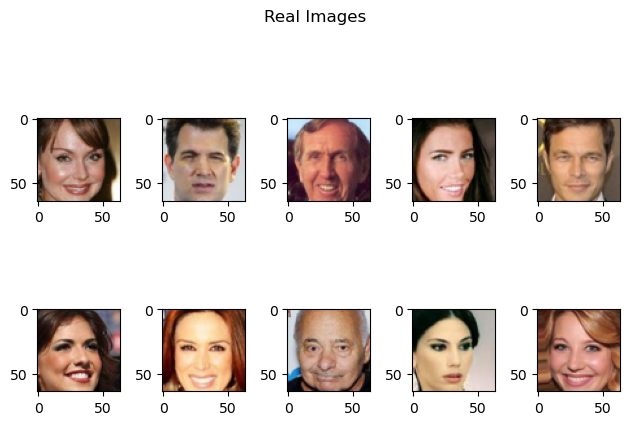

In [5]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(training_images[idx].reshape(64,64,3))
        idx+=6
plt.tight_layout()
plt.show()

In [6]:
noise_shape=100
#Generator will upsample our seed using convolutional transpose layers (upsampling layers)
def generator_model():
    generator=Sequential()
    
    #Random noise to 4x4x512 image
    generator.add(Dense(4*4*512, input_shape=[noise_shape]))
    generator.add(Reshape([4,4,512]))
    generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    #Batchnormalisation is added to the model after the hidden layer, but before the activation, such as LeakyReLU.
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    
    generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'))
    
    return generator

generator = generator_model()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585,219 (13.68 MB)

 Trainable params: 3,584,323 (13.67 MB)

 Non-trainable params: 896 (3.50 KB)

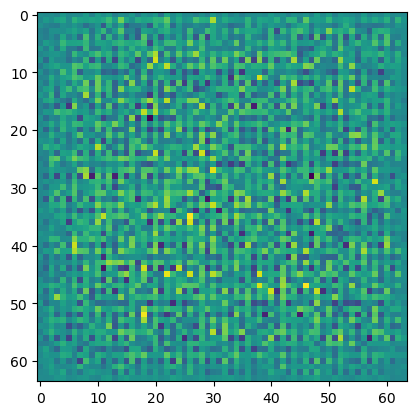

In [7]:
# First create a random noise
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
# Print Image Genetared Image from Noise
plt.imshow(generated_image[0, :, :, 0])

In [8]:
def discriminator_model():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=[64,64, 3]))
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    discriminator.add(BatchNormalization())
    
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Flatten())
    
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

discriminator = discriminator_model()

discriminator.summary()
    

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,233 (215.75 KB)

 Non-trainable params: 128 (512.00 B)

In [9]:
GAN = Sequential([generator, discriminator])

discriminator.compile(optimizer='adam', loss=binary_crossentropy)

discriminator.trainable = False  #we are not training discriminator freely, its only trainable along with the generator through the GAN

GAN.compile(optimizer='adam', loss='binary_crossentropy')

GAN.layers

GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │     3,585,219 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │        55,361 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,640,580 (13.89 MB)

 Trainable params: 3,584,323 (13.67 MB)

 Non-trainable params: 56,257 (219.75 KB)

Currently training on Epoch 1
	Currently training on batch number 0 of 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


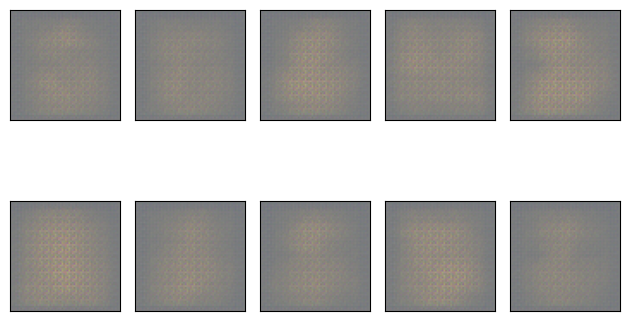

Epoch: 1,  Loss: D_real = 0.591, D_fake = 0.573,  G = 0.573
Currently training on Epoch 2
	Currently training on batch number 0 of 15
Epoch: 2,  Loss: D_real = 0.329, D_fake = 0.324,  G = 0.324
Currently training on Epoch 3
	Currently training on batch number 0 of 15
Epoch: 3,  Loss: D_real = 0.222, D_fake = 0.220,  G = 0.220
Currently training on Epoch 4
	Currently training on batch number 0 of 15
Epoch: 4,  Loss: D_real = 0.167, D_fake = 0.166,  G = 0.166
Currently training on Epoch 5
	Currently training on batch number 0 of 15
Epoch: 5,  Loss: D_real = 0.134, D_fake = 0.133,  G = 0.133
Currently training on Epoch 6
	Currently training on batch number 0 of 15
Epoch: 6,  Loss: D_real = 0.111, D_fake = 0.111,  G = 0.111
Currently training on Epoch 7
	Currently training on batch number 0 of 15
Epoch: 7,  Loss: D_real = 0.095, D_fake = 0.095,  G = 0.095
Currently training on Epoch 8
	Currently training on batch number 0 of 15
Epoch: 8,  Loss: D_real = 0.083, D_fake = 0.083,  G = 0.083
Cu

In [10]:
epochs = 10
batch_size = 64

loss_from_discriminator_model=[] # Array to collect loss for the discriminator model

loss_from_generator_model=[] # Array to collect loss for generator model

with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently training on Epoch {epoch+1}")
    
    # Loop over each batch in the dataset
    for i in range(training_images.shape[0]//batch_size):
    # Benefits of Double Division Operator over Single Division Operator in Python
    # The Double Division operator in Python returns the floor value for both integer and floating-point arguments after division.
        
        if (i)%100 == 0:
            print(f"\tCurrently training on batch number {i} of {len(training_images)//batch_size}")
        
        #  Start by sampling a batch of noise vectors from a uniform distribution
        # generator receives a random seed as input which is used to produce an image.
        noise=np.random.uniform(-1,1,size=[batch_size, noise_shape])
        
        ''' Generate a batch of fake images using the generator network
        
        The difference between predict() and predict_on_batch() - lies in when you pass as x data that is larger than one batch.

        predict() -  will go through all the data, batch by batch, predicting labels. It thus internally does the splitting in batches and feeding one batch at a time.

        predict_on_batch() - on the other hand, assumes that the data you pass in is exactly one batch and thus feeds it to the network. It will not try to split it
        
        In summary, predict method has extra operations to ensure a collection of batches are processed right, whereas, predict_on_batch is a lightweight alternative to predict that should be used on a single batch.
        '''
        gen_image = generator.predict_on_batch(noise)
        # We do this by first sampling some random noise from a random uniform distribution, 
        # then getting the generator’s predictions on the noise. 
        # The noise variable is the code equivalent of the variable z, which we discussed earlier.
        
        # Now I am taking real x_train data
        # by sampling a batch of real images from the set of all image
        train_dataset = training_images[i*batch_size:(i+1)*batch_size]
        
        # Create Labels
        # First training on real image
        train_labels_real=np.ones(shape=(batch_size,1))
        
        discriminator.trainable = True
        
        #  Next, train the discriminator network on real images and real labels:
        d_loss_real = discriminator.train_on_batch(train_dataset,train_labels_real)
        #print("d_loss_real = ", d_loss_real)
        #Now training on fake image
        train_labels_fake=np.zeros(shape=(batch_size,1))
        
        d_loss_fake = discriminator.train_on_batch(gen_image,train_labels_fake)
        #print("d_loss_fake =", d_loss_fake)
        # Creating variables to make ready the whole adversarial network
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        # Image Label vector that has all the values equal to 1
        # To fool the Discriminator Network
        train_label_fake_for_gen_training =np.ones(shape=(batch_size,1))
        
        discriminator.trainable = False
        
        ''' Now train the generator
        To train the generator network, we have to train the adversarial model.
        When we train the adversarial model, it trains the generator network only
        but freezes the discriminator network. We won't train the discriminator
        network, as we have already trained it.
        '''
        g_loss = GAN.train_on_batch(noise, train_label_fake_for_gen_training)
        #print("g_loss =", g_loss)
        ''' So what I am doing above in short is,
        I train the adversarial model on the batch of noise vectors and real
        labels. Here, real labels is a vector with all values equal to 1. 
        
        I am also training the generator to fool the discriminator network. To do
        this, I provide it with a vector that has all the values equal to 1. 
        
        In this step, the generator will receive feedback from the generator
        network and improve itself accordingly.
        '''
        
        loss_from_discriminator_model.append(d_loss_real+d_loss_fake)
        
        loss_from_generator_model.append(g_loss)
        
    ''' There is a passive method to evaluate the training process. After every 50
    epochs, generate fake images and manually check the quality of the images:
    These images will help you to decide whether to continue the training or to
    stop it early. Stop the training if quality of the generated high-resolution
    images is good. Or continue the training until your model becomes good.

    '''
    if epoch % 50 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' % (epoch+1, d_loss_real, d_loss_fake, g_loss[0]))   

print('Training completed with all epochs')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

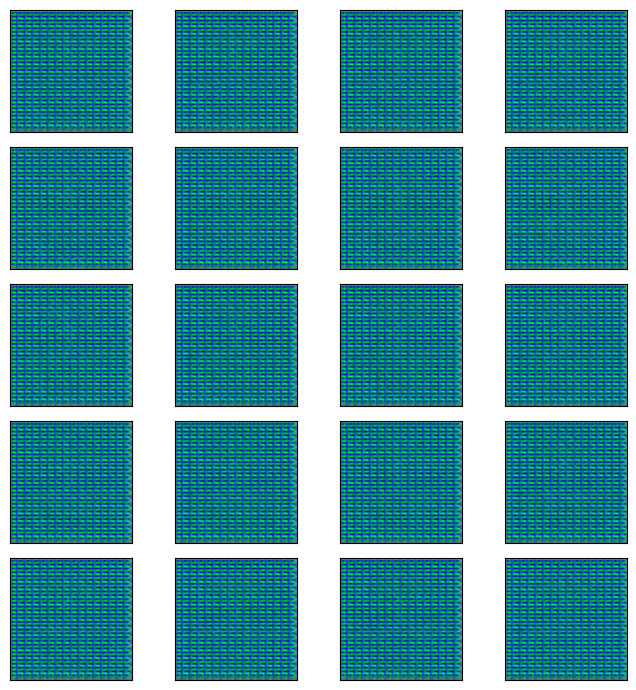

In [11]:
noise = np.random.uniform(-1,1,size=[100, noise_shape])

im=generator.predict(noise)

for i in range(5):
    plt.figure(figsize=(7,7))
for k in range(20):
    noise=np.random.uniform(-1,1,size=[100,noise_shape])
    im=generator.predict(noise)
    plt.subplot(5, 4, k+1)
    plt.imshow(im[k].reshape(64,64,3))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()